# Demonstrating ImplicitFiniteDifference class

In this notebook, I will demonstrate the functionality of the `ImplicitFiniteDifference` and `Option` classes defined in `methods.implicitfinitedifference` and `methods.option` respectively. I will do this by working through an exercises proposed in:

**Hull, J. C. (2003).** *Options, Futures, and Other Derivatives* (2nd ed.). Prentice-Hall. Chapter 14: Numerical Methods.

I will do this using both implicit and explicit finite differences and will observe the convergence of the model answer to the correct price of the option.

### Contents
1. [Implicit Finite Differences](#implicit-finite-differences)
2. [Convergence to solution of Black-Scholes differential equation](#convergence-to-solution-of-black-scholes-differential-equation)
3. [Explicit Finite Differences](#explicit-finite-differences)

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from methods.implicitfinitedifference import ImplicitFiniteDifference
from methods.option import Option, Put, Call
from methods.node import Node

import matplotlib.pyplot as plt

## Implicit Finite Differences

## Ex 14.1 American Put on no-dividend asset

In [2]:
# Time to maturity
T = 0.4167
# Number of timesteps
tsteps = 10
# Boundary value of asset price
Smax = 100
# Value steps
vsteps = 20
# Boundary option prices
fmax = 0
fmin = 50
# Current asset price
S = 50
# Option to price
X = 50
option = Put(X, american = True)
# Risk free interest rate and asset volatility (we assume these are constant up
# to maturity). ImplicitFiniteDifference class can be extended so that these
# can be a function of time.
r = 0.10
sigma = 0.40

In [3]:
# Initialize and fit ImplicitFiniteDifference model
american_put_model = ImplicitFiniteDifference(T, tsteps, Smax, vsteps, fmax, fmin)
american_put_model.fit(r=r, sigma=sigma, S=S, option=option)

In [4]:
print(f'The computed option price for the given american put is {american_put_model.f:.5f} dollars.')

The computed option price for the given american put is 4.06732 dollars.


In [5]:
american_put_model.show()

Time (years),0.00 [0],0.04 [1],0.08 [2],0.13 [3],0.17 [4],0.21 [5],0.25 [6],0.29 [7],0.33 [8],0.38 [9],0.42 [10]
Asset Price (dollars),,,,,,,,,,,
100.00 [20],0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
95.00 [19],0.02,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
90.00 [18],0.05,0.04,0.03,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00
85.00 [17],0.09,0.07,0.05,0.03,0.02,0.01,0.01,0.00,0.00,0.00,0.00
80.00 [16],0.16,0.12,0.09,0.07,0.04,0.03,0.02,0.01,0.00,0.00,0.00
75.00 [15],0.27,0.22,0.17,0.13,0.09,0.06,0.03,0.02,0.01,0.00,0.00
70.00 [14],0.47,0.39,0.32,0.25,0.18,0.13,0.08,0.04,0.02,0.00,0.00
65.00 [13],0.82,0.71,0.60,0.49,0.38,0.28,0.19,0.11,0.05,0.02,0.00
60.00 [12],1.42,1.27,1.11,0.95,0.78,0.62,0.45,0.30,0.16,0.05,0.00


In [6]:
# A logarithmic scale is applied to give a visual representation of varying option prices as a function of time
# and underlying asset price
american_put_model.show(heat=True, scale='log')

Time (years),0.00 [0],0.04 [1],0.08 [2],0.13 [3],0.17 [4],0.21 [5],0.25 [6],0.29 [7],0.33 [8],0.38 [9],0.42 [10]
Asset Price (dollars),,,,,,,,,,,
100.00 [20],0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
95.00 [19],0.02,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
90.00 [18],0.05,0.04,0.03,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00
85.00 [17],0.09,0.07,0.05,0.03,0.02,0.01,0.01,0.00,0.00,0.00,0.00
80.00 [16],0.16,0.12,0.09,0.07,0.04,0.03,0.02,0.01,0.00,0.00,0.00
75.00 [15],0.27,0.22,0.17,0.13,0.09,0.06,0.03,0.02,0.01,0.00,0.00
70.00 [14],0.47,0.39,0.32,0.25,0.18,0.13,0.08,0.04,0.02,0.00,0.00
65.00 [13],0.82,0.71,0.60,0.49,0.38,0.28,0.19,0.11,0.05,0.02,0.00
60.00 [12],1.42,1.27,1.11,0.95,0.78,0.62,0.45,0.30,0.16,0.05,0.00


# Convergence to solution of Black-Scholes differential equation

We can visualize how the model converges to the solution of the Black Scholes equation with the given boundary conditions by increasing the value of tsteps (i.e. bringing the module closer to continuous time computation) and vsteps (underlying asset price closer to continuous spectrum).
The text followed suggest keeping the price steps proportional to the square root of the time steps as they approach zero: this give vsteps proportional to square root of tsteps.

In [7]:
initial_vvalue = 20
initial_tvalue = 10
alpha = initial_vvalue/(initial_tvalue)**(1/2)

vvalues = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
tvalues = [int((v/alpha)**2) for v in vvalues]
fvalues = []
for i in range(len(vvalues)):
    model = ImplicitFiniteDifference(T, tvalues[i], Smax, vvalues[i], fmax, fmin)
    model.fit(r=r, sigma=sigma, S=S, option=option)
    fvalues.append(model.f)

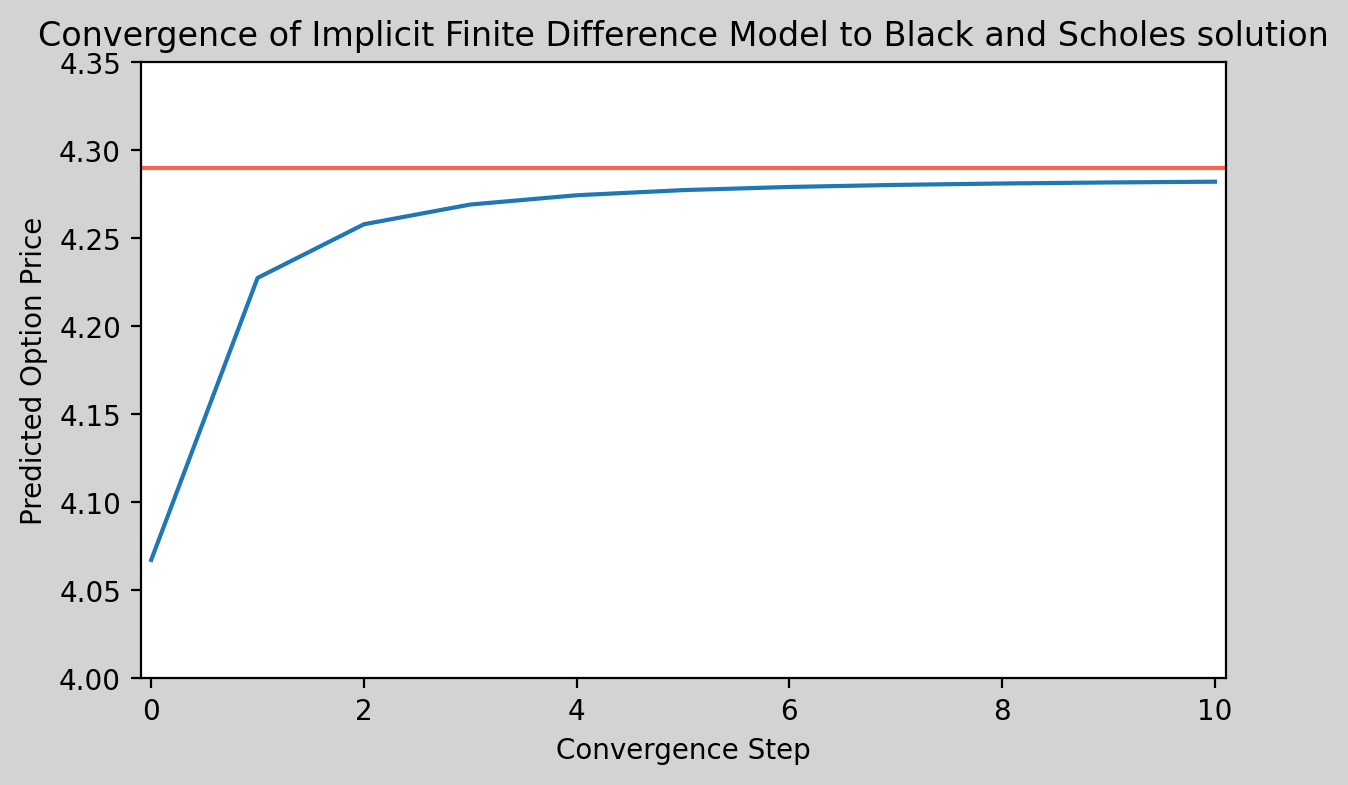

In [8]:
plt.figure(figsize=(7,4), dpi=200, facecolor='lightgray')
plt.plot(range(len(vvalues)), fvalues)
plt.title('Convergence of Implicit Finite Difference Model to Black and Scholes solution')
plt.xlabel('Convergence Step')
plt.ylabel('Predicted Option Price')
plt.ylim((4,4.35))
plt.xlim((-0.1,len(vvalues)-0.9))
plt.axhline(4.29, color='tomato')
plt.show()

---

## Explicit Finite Differences

The `ImplicitFiniteDifference` class also implements explicit finite differences computation: note that this method is based on the assumption that the delta and gamma of the derivative considered are extremely similar between adjacent time points and are therefore interchangeable in the finite differences approximation of the Black-Scholes equation. This is close to true when timesteps are very small but in some cases can lead to null results as is shown below.

This is done to simplify the equations behind implicit finite differences and to avoid inverting a matrix: however, inverting a matrix with the numpy library is very efficient and the explicit method's necessity of smaller timesteps slows computation down considerably when decreasing timestep and underlying value step size to converge to the Black-Scholes equation's solution. 

We will work with the same example as above.

In [9]:
# Time to maturity
T = 0.4167
# Number of timesteps
tsteps = 10
# Boundary value of asset price
Smax = 100
# Value steps
vsteps = 20
# Boundary option prices
fmax = 0
fmin = 50
# Current asset price
S = 50
# Option to price
X = 50
option = Put(X, american = True)
# Risk free interest rate and asset volatility (we assume these are constant up
# to maturity). ImplicitFiniteDifference class can be extended so that these
# can be a function of time.
r = 0.10
sigma = 0.40

In [10]:
# Initialize both implicit and explicit models, note they are identical but 
# we will use a different fit function on each.
implicit_model = ImplicitFiniteDifference(T, tsteps, Smax, vsteps, fmax, fmin)
explicit_model = ImplicitFiniteDifference(T, tsteps, Smax, vsteps, fmax, fmin)

implicit_model.fit(r=r, sigma=sigma, S=S, option=option)
explicit_model.explicit_fit(r=r, sigma=sigma, S=S, option=option)

In [11]:
print(f'The computed option price for the implicit model is {implicit_model.f:.5f} dollars.')
print(f'The computed option price for the explicit model is {explicit_model.f:.5f} dollars.')

The computed option price for the implicit model is 4.06732 dollars.
The computed option price for the explicit model is 4.25695 dollars.


We can see that the two models give considerably different results. The explicit model's map also shows something unusual happening:

In [12]:
explicit_model.show(heat=True, scale='log')

Time (years),0.00 [0],0.04 [1],0.08 [2],0.13 [3],0.17 [4],0.21 [5],0.25 [6],0.29 [7],0.33 [8],0.38 [9],0.42 [10]
Asset Price (dollars),,,,,,,,,,,
100.00 [20],0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
95.00 [19],0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
90.00 [18],-0.11,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
85.00 [17],0.28,-0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
80.00 [16],-0.13,0.20,-0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75.00 [15],0.46,0.06,0.20,0.04,0.06,0.00,0.00,0.00,0.00,0.00,0.00
70.00 [14],0.32,0.46,0.23,0.25,0.10,0.09,0.00,0.00,0.00,0.00,0.00
65.00 [13],0.91,0.68,0.63,0.44,0.37,0.21,0.14,0.00,0.00,0.00,0.00
60.00 [12],1.48,1.37,1.17,1.02,0.81,0.65,0.42,0.27,0.00,0.00,0.00


We can see that the model allows negative values for the derivative's price (the ability to exercise the put early is overwritten to show this problem). This shows that the assumption which allows explicit finite differences does not hold well in this case and therefore leads to negative values for an option with positive payoff, which is not reasonable.

By increasing the tsteps attribute, meaning timesteps in the models are smaller, the assumption holds better and the two models predict much closer values.

In [13]:
tsteps = 500

# Initialize both implicit and explicit models, note they are identical but 
# we will use a different fit function on each.
implicit_model = ImplicitFiniteDifference(T, tsteps, Smax, vsteps, fmax, fmin)
explicit_model = ImplicitFiniteDifference(T, tsteps, Smax, vsteps, fmax, fmin)

implicit_model.fit(r=r, sigma=sigma, S=S, option=option)
explicit_model.explicit_fit(r=r, sigma=sigma, S=S, option=option)

print(f'The computed option price for the implicit model is {implicit_model.f:.5f} dollars.')
print(f'The computed option price for the explicit model is {explicit_model.f:.5f} dollars.')

The computed option price for the implicit model is 4.17212 dollars.
The computed option price for the explicit model is 4.17594 dollars.


Additionally, no negative values appear in the method's map:

In [14]:
explicit_model.show(heat=True, scale='log')